In [1]:
import numpy as np                # library for mathematical operations with arrays
import pandas as pd               # library for data frames; includes useful functions for date arithmetic
import xarray as xr               # library for arrays, especially tailored to weather data
import matplotlib.pyplot as plt   # library for basic plotting

from os import path                              # library for operating system commands related to file paths
from matplotlib.colors import ListedColormap     # function for creating custom colormap
from scipy.ndimage import median_filter          # function for smoothing images
from onset import calculate_onset_hist           # function to calculate historical rainy season onset dates
from onset import calculate_adjusted_thresholds  # function to calculate the bias-corrected threshold values
from onset import calculate_onset_fcst           # function to calculate rainy season onset forecasts
from plotting import plot_fields                 # function for visualizing spatial data in a map
from plotting import get_nearest_grid_index      # helper function to find the grid indices for a selected location

# Load some fixed, global parameters
from glp import domain_boundaries, climatological_reference_period, global_parameters

In [2]:
data_dir = '/home/michael/data/CONFER/RainOnset/realtime/'

Set the variables that define the season and region in which we search for rainy season onset, and three parameters that determine how the rainy season onset date is defined.

The default values used by ICPAC are thr_wet = 20, thr_dry = 1, and len_dry_spell = 7. However, for drier regions within GHA, these values can lead to a large number of years with a 'failed onset' because the onset criterion is not met. The subsequent cells will evaluate that and mask grid points with too many failed onset. If too many grid points are masked, we recommend adjusting these values and e.g. permit longer dry spells or lower the threshold for a wet spell.

In [3]:
region = 'Uganda'    # Either 'GHA' for the entire domain or any country name within the GHA region

year_fcst = 2023     # year for which a rainy season onset date should be predicted
month_start = 8      # month in which we start the onset date search (specifically: the 15th of this month)
system = 'ecmwf'     # forecast system on which the rainy season onset forecasts will be based

thr_wet = 20         # the rainfall amount within 3 days required to consider these days a 'wet spell'
thr_dry = 1          # the daily rainfall amount below which the day will be considered a 'dry day'
len_dry_spell = 7    # number of consecutive dry days within 21 days after a wet spell that will invalidate an onset

Load global parameters:

In [4]:
lon_bounds, lat_bounds = domain_boundaries(region)
year_clm_start, year_clm_end = climatological_reference_period()
day_start, nwks, ndts, ntwd = global_parameters()

date_start = f'{year_fcst}-{month_start}-{day_start}'

f1 = np.load(data_dir+'onset_colors.npz')
onsetcol = f1['onsetcol']
f1.close()
newcmp_onset = ListedColormap(onsetcol)

Load longitude and latitude coordinates of the target grid:

In [5]:
filename_chirps = f'{data_dir}CHIRPS_daily_{year_clm_start}-{year_clm_end}_{month_start}.nc'
data_load = xr.open_dataset(filename_chirps, engine='netcdf4')
data_subset = data_load.sel(lat=slice(lat_bounds[0],lat_bounds[1]), lon=slice(lon_bounds[0],lon_bounds[1]))
lon_chirps = data_subset.lon.values
lat_chirps = data_subset.lat.values
data_load.close()

nlat = len(lat_chirps)
nlon = len(lon_chirps)

/home/michael/.local/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Create the mask for the onset definition:

In [6]:
thr_wet_orig = np.full((nlat,nlon), thr_wet, dtype=float)
thr_dry_orig = np.full((nlat,nlon), thr_dry, dtype=float)
len_dry_spell_orig = np.full((nlat,nlon), len_dry_spell, dtype=int)

Calculate historical rainy season onset dates based on CHIRPSv2 data with the onset definition parameters specified above:

In [7]:
onset_day_hist = calculate_onset_hist(region, month_start, thr_dry_orig, thr_wet_orig, len_dry_spell_orig, data_dir)
onset_week_hist = 1 + (onset_day_hist-1)//7

We check whether over the specified region and with the selected start month and onset definition parameters the historical outcome is mostly (except for 10 years or less) a failed onset or an immediate (within 5 days of the start of the search period) onset. If that is the case, the respective grid points are masked:

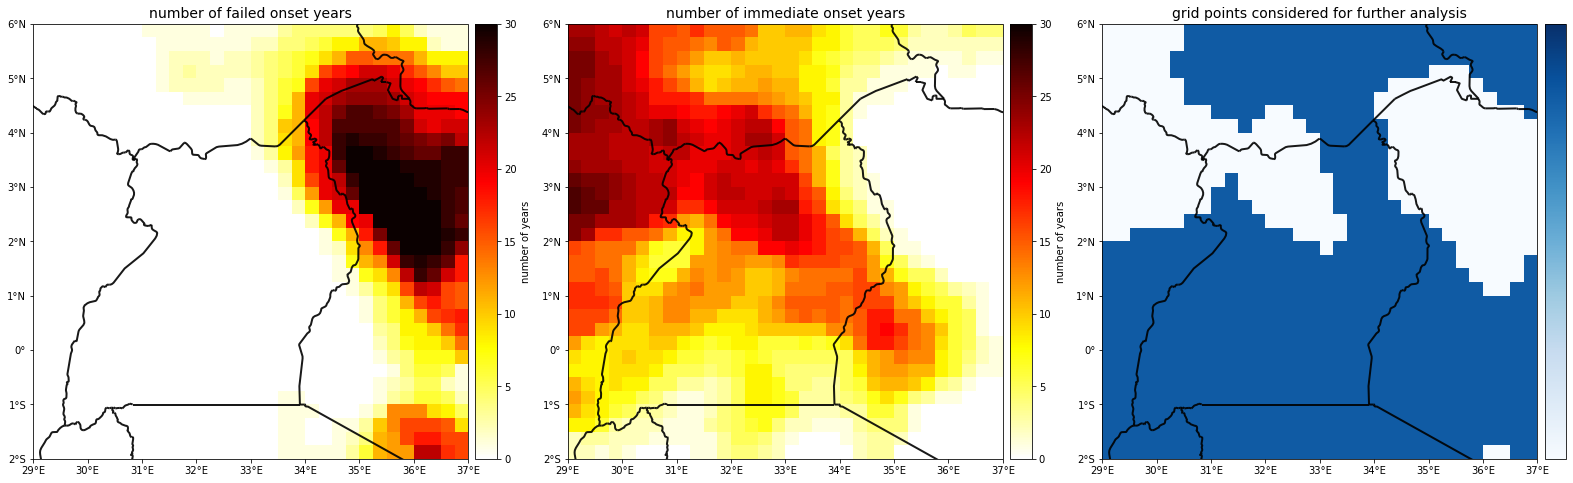

In [8]:
nyrs = onset_day_hist.shape[0]
missing_data_ind = np.all(np.isnan(onset_day_hist), axis=0)
nyrs_failed_onset = np.where(missing_data_ind, np.nan, median_filter(np.sum(onset_day_hist<0, axis=0), size=3))
nyrs_immediate_onset = np.where(missing_data_ind, np.nan, median_filter(np.sum(np.logical_and(onset_day_hist>0, onset_day_hist<6), axis=0), size=3))
mask = np.logical_or(missing_data_ind, np.logical_or(nyrs_failed_onset>=nyrs-10, nyrs_immediate_onset>=nyrs-10))

plot_fields (fields_list = [nyrs_failed_onset, nyrs_immediate_onset, 1*(~mask)],
          lon = lon_chirps,
          lat = lat_chirps,
          lon_bounds = lon_bounds,
          lat_bounds = lat_bounds,
          main_title = '',
          subtitle_list = ['number of failed onset years', 'number of immediate onset years', 'grid points considered for further analysis'],
          cmap = ['hot_r','hot_r','Blues'],
          vmin = 0,
          vmax = [nyrs,nyrs,1.2],
          ticks = [True, True, []],
          tick_labels = [True, True, []],
          unit = ['number of years', 'number of years',''])

if np.mean(~mask) < 0.1:
    print('\nWarning! Less than 10% of the grid points in the selected region is considered for further analysis! \n\nPlease check if the selected start month and parameters defining onset are suitable for this region.\n')

thr_wet_orig[mask] = np.nan
thr_dry_orig[mask] = np.nan

Let's calculate and depict the median and lower/upper onset date tercile in a map, using the mask defined above:

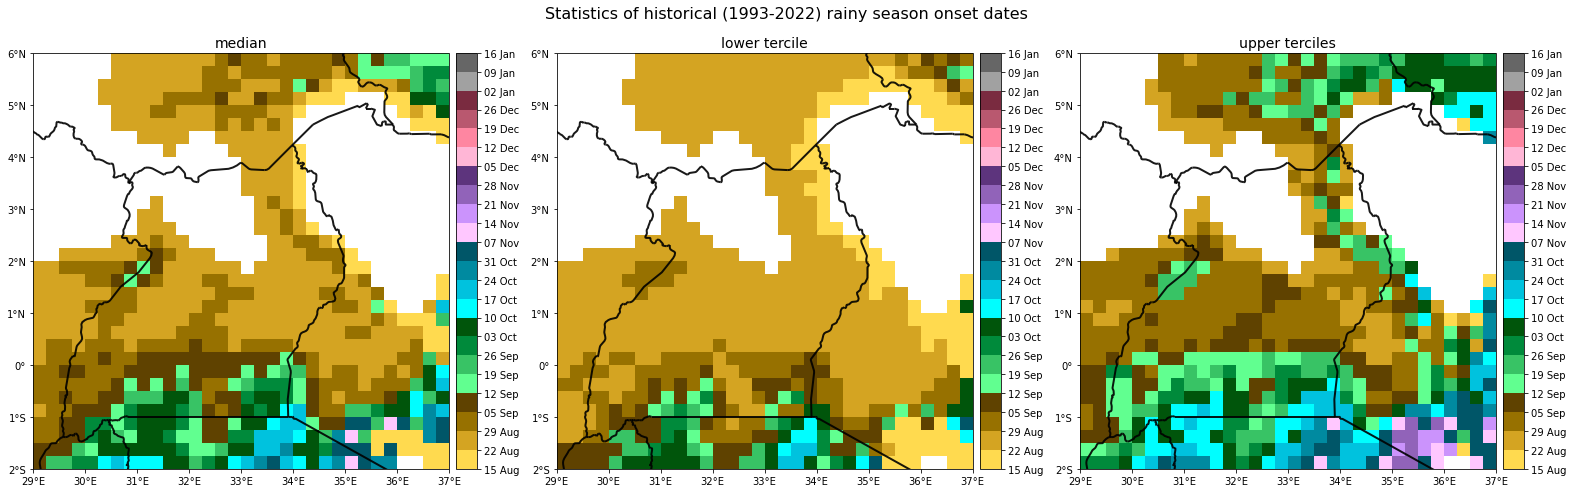

In [9]:
onset_day_median = np.median(np.where(mask, np.nan, onset_day_hist), axis=0)
onset_week_median = np.where(mask, np.nan, 1 + (onset_day_median-1)//7)
onset_day_lower_tercile = np.quantile(np.where(mask, np.nan, onset_day_hist), q=0.33, axis=0)
onset_week_lower_tercile = np.where(mask, np.nan, 1 + (onset_day_lower_tercile-1)//7)
onset_day_upper_tercile = np.quantile(np.where(mask, np.nan, onset_day_hist), q=0.67, axis=0)
onset_week_upper_tercile = np.where(mask, np.nan, 1 + (onset_day_upper_tercile-1)//7)

onset_week_labels = [(pd.Timestamp(date_start)+pd.Timedelta(days=7*iwk)).strftime("%d %b") for iwk in range(nwks+1)]

plot_fields (fields_list = [onset_week_median, onset_week_lower_tercile, onset_week_upper_tercile],
          lon = lon_chirps,
          lat = lat_chirps,
          lon_bounds = lon_bounds,
          lat_bounds = lat_bounds,
          main_title = 'Statistics of historical (1993-2022) rainy season onset dates',
          subtitle_list = ['median', 'lower tercile', 'upper terciles'],
          cmap = newcmp_onset,
          vmin = 0,
          vmax = nwks,
          ticks = [*range(nwks+1)],
          tick_labels = onset_week_labels,
          unit = '')

Now we calculate the bias-adjusted threshold parameters for the selected forecast system. For a large region, this can take some time:

In [10]:
thr_dry_adj, thr_wet_adj = calculate_adjusted_thresholds(region, month_start, system, thr_dry_orig, thr_wet_orig, data_dir)

Depict the bias-adjusted threshold values for 1-day (-> dry spell) and 3-day (wet-spell) precipitation amounts:

In [11]:
#idt = 93    # lead time to be plotted (recall that the adjusted thresholds vary with lead time)
#
#date_str = (pd.Timestamp(f'{year_fcst}-{month_start}-{15}')+pd.Timedelta(days=idt)).strftime("%Y-%m-%d")
#
#plot_fields (fields_list = [thr_dry_adj[idt,:,:], thr_wet_adj[idt,:,:]],
#          lon = lon_chirps,
#          lat = lat_chirps,
#          lon_bounds = lon_bounds,
#          lat_bounds = lat_bounds,
#          main_title = f'Adjusted threshold values for {date_str}',
#          subtitle_list = ['threshold for 1 mm / day','threshold for  20 mm / 3 days'],
#          vmin = [0,0],
#          vmax = [5,50],
#          unit = 'mm')

Now, we are ready to calculate the rainy season onset prediction for the selected year:

In [12]:
onset_day_fcst = calculate_onset_fcst(region, month_start, year_fcst, system, thr_dry_adj, thr_wet_adj, len_dry_spell_orig, lat_chirps, lon_chirps, data_dir)
onset_week_fcst = 1 + (onset_day_fcst-1)//7

The above calculation gives us an ensemble of rainy season onset dates at each gridpoint within the selected region. At individual locations, we can compare the probabilities of forecast and historic rainy season onset dates to fall into a particular week:


Text(0.5, 1.0, 'Probability for rainy season onset in Kampala to occur within a given week')

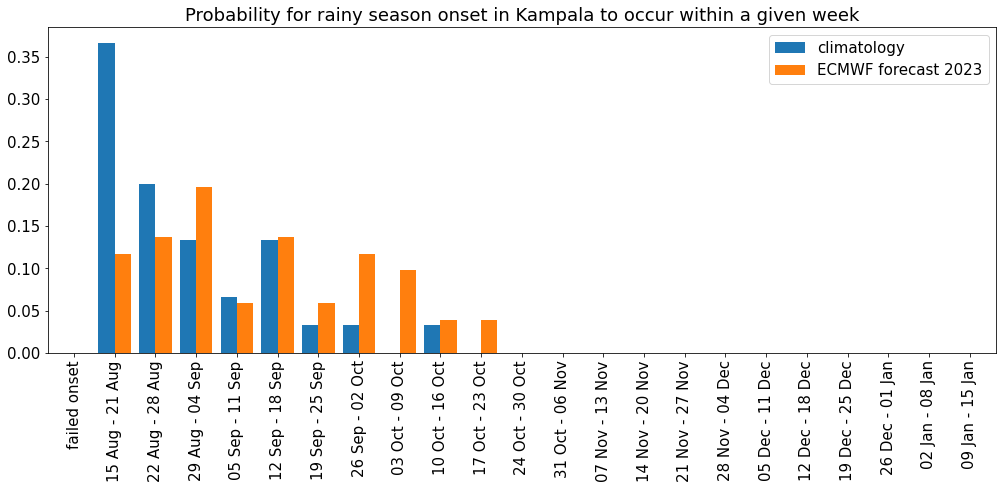

In [13]:
#lon_exmpl = 36.82       # longitude of example location
#lat_exmpl = -1.29       # latitude of example location
#name_exmpl = 'Nairobi'  # name of the selected location

#lon_exmpl = 38.75           # longitude of example location
#lat_exmpl =  9.00           # latitude of example location
#name_exmpl = 'Addis Abeba'  # name of the selected location

lon_exmpl = 32.56       # longitude of example location
lat_exmpl =  0.31       # latitude of example location
name_exmpl = 'Kampala'  # name of the selected location

#lon_exmpl = 45.33         # longitude of example location
#lat_exmpl =  2.05         # latitude of example location
#name_exmpl = 'Moghadishu' # name of the selected location

#lon_exmpl = 39.21            # longitude of example location
#lat_exmpl = -6.84            # latitude of example location
#name_exmpl = 'Dar-es-Salaam' # name of the selected location

#lon_exmpl = 30.09       # longitude of example location
#lat_exmpl = -1.96       # latitude of example location
#name_exmpl = 'Kigali'   # name of the selected location



ix, iy = get_nearest_grid_index(lon_exmpl, lat_exmpl, lon_chirps, lat_chirps)

date_range_weeks = ['failed onset']+[(pd.Timestamp(date_start)+pd.Timedelta(days=7*iwk)).strftime("%d %b")+' - '+(pd.Timestamp(date_start)+pd.Timedelta(days=7*iwk+6)).strftime("%d %b") for iwk in range(nwks)]

df_onset_prob = pd.DataFrame(index=date_range_weeks, columns=['climatology',f'{system.upper()} forecast {year_fcst}'])
df_onset_prob['climatology'] = np.mean(np.equal.outer(onset_week_hist[:,iy,ix],np.arange(nwks+1)), axis=0)
df_onset_prob[f'{system.upper()} forecast {year_fcst}'] = np.mean(np.equal.outer(onset_week_fcst[:,iy,ix],np.arange(nwks+1)), axis=0)

plt.figure(figsize=(17,6))
ax = plt.subplot(1, 1, 1)
df_onset_prob.plot.bar(ax=ax, width=0.8, fontsize=15).legend(fontsize=15)
ax.set_title(f'Probability for rainy season onset in {name_exmpl} to occur within a given week', fontsize=18)

Finally, let's calculate and depict probability forecasts for rainy season onset to occur earlier than the lower climatological tercile and later than the upper climatological tercile (ignoring 'failed onset' cases both among ensemble forecasts and historical cases):

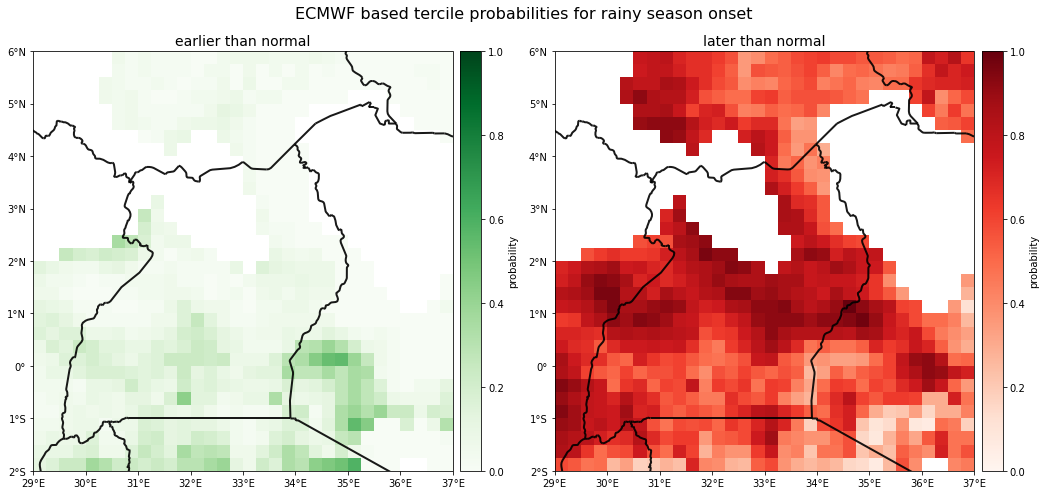

In [14]:
prob_fcst_bn = np.where(mask, np.nan, np.mean(np.less_equal(np.where(onset_day_fcst<0, np.nan, onset_day_fcst), onset_day_lower_tercile[None,:,:]), axis=0))
prob_fcst_an = np.where(mask, np.nan, np.mean(np.greater_equal(np.where(onset_day_fcst<0, np.nan, onset_day_fcst), onset_day_upper_tercile[None,:,:]), axis=0))

plot_fields (fields_list = [prob_fcst_bn, prob_fcst_an],
          lon = lon_chirps,
          lat = lat_chirps,
          lon_bounds = lon_bounds,
          lat_bounds = lat_bounds,
          main_title = f'{system.upper()} based tercile probabilities for rainy season onset',
          subtitle_list = ['earlier than normal','later than normal'],
          cmap = ['Greens','Reds'],
          vmin = 0,
          vmax = 1,
          unit = 'probability')